## Visualizing results -  Original Geoparser

We have run the [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) to extract and resolvoe locations contained within the **First Edition, Volume 1, A-B** (year 1771) of the *Encyclopaedia Britannica*, which has 832 pages.
                             
The query for running that we have used is the following: 

`spark-submit --py-files defoe.zip defoe/run_query.py nls_subsample.txt nls defoe.nls.queries.geoparser_pages -r geopaser_original_EB_144133901 -n 16`

The nls_subsample.txt has the path of this particular book that we are exploring:

`xxx/nls-data-encyclopaediaBritannica/144133901`

The results file ( [geopaser_original_EB_144133901](http://localhost:8888/edit/results_NLS/geopaser_original_EB_144133901)) is stored in this repository under the *results_NLS* subdirectory. 


### Loading the necessary libraries

In [21]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
mpl.rcParams['figure.dpi']=300

### Functions

In [2]:
def read_query_results(filename):
    with open('./results_NLS/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]
    for i in result.keys():
        t_ind = 0
        e_ind = 0
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
       
            if locs != {}:
                data=[]
                l_ind = 0
                for i in locs:
                    if type(locs[i]) == type([]) :
                        c_locs=locs[i].copy()
                        c_locs.append(i.split("-")[0])
                        c_locs.append(page)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [4]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df_total['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [5]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'] )
        if place_name not in filter_list:
            print(i, place_count,place_name)
            place_label.append(place_name)
            place_freq.append(place_count)
            k = k + 1
        i = i + 1
    return place_label, place_freq

In [26]:
def plot_bar_places(place_label, place_freq):
    # this is for plotting purpose
    index = np.arange(len(place_label))
    plt.bar(index, place_freq, color='orange')
    plt.xlabel('Places')
    plt.ylabel('Frequency of Places')
    plt.xticks(index, place_label, rotation=40, fontsize=8)
    plt.title('15 Places most mentioned in the using the Original Geoparser')
    #plt.show()
    plt.savefig('Original1stBook1stEdition.png', dpi=300)

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages from the directory "144133901",  which corresponds to the book "Encyclopaedia Britannica; or, A dictionary of arts and sciences, compiled upon a new plan … - First edition, 1771, Volume 1, A-B - EB.1"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original geotagging of the Edinburgh geoparser. 
- From the previous entities, just selects the one about *location* and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by Book's title, and also gets some informative metadata

As a result we get a file per gazetter|book with an entry per page with the following information:

    * archive_filename: Path to the gazetteer 
    * clean_text: Page's clean text after applying 2 fixes: long-S and hyphenate words
    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * model: defoe model – could be fmp|nls|papers|alto. In this case is “nls”
    * text_unit: page (for other defoe models could be “article”)
    * num_text_unit: number of tex units. In this case, number of pages of this particular book (e.g. 832)
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (original_geoparser)
    * type_distribution: type of document (newspaper|book). In this case is "book". 
    * year: Publication year 


Example:
  - archive_filename: /home/tdm/datasets/encyclopaedia-britannica-sample/144133901
  - clean_text: "ARTS and SCIENCES, COVI PILED UPON A NEW PLAN. IN WHICH The diferent
    SCIENCES and ARTS are dioefted into " O diflinct Treatifes or Syitems; AND . The
    \irious TECHNIC A LTERMS, <&C. are explained as they occur in the order of the
    Alphabet. ILLUSTRATED WITH ONE HUNDRED AND SIXTY COPPERPLATES. fry a SOCIETY of
    GENTLEMEN in SCOTLAND .... "
    
  - edition: First edition, 1771, Volume 1, A-B
  - georesolution_page:
    SCOTLAND-rb3:
        - '56'
        - '-4'
  - lang_model: geoparser_original
  - model: nls
  - num_text_unit: 832
  - page_filename: alto/188082826.34.xml
  - place: Edinburgh
  - text_unit: page
  - text_unit id: Page9
  - type_distribution: book
  - year: 1771



In [7]:
results=read_query_results('geopaser_original_EB_144133901')

In [8]:
df_total= geresolution_dataframe(results)

In [9]:
df_total[["Place"]].count()

Place    5872
dtype: int64

In [10]:
df_total.groupby("Place").count()

,Latitude,Longitude,Page
Place,,,
AACH,1,1,1
AADE,1,1,1
ABACA,1,1,1
ABACH,1,1,1
ABACO,1,1,1
ABADAN,1,1,1
ABADIR,1,1,1
ABAI,1,1,1
ABANCAI,1,1,1


In [11]:
df_total.groupby("Page").count()

,Latitude,Longitude,Place
Page,,,
Page100,9,9,9
Page101,42,42,42
Page102,27,27,27
Page103,39,39,39
Page104,27,27,27
Page105,36,36,36
Page106,43,43,43
Page109,23,23,23
Page110,24,24,24


In [12]:
df_total.groupby(["Latitude", "Longitude"]).count()

Place  Page
Latitude  Longitude             
                      3647  3647
-1        15.5           1     1
-1.2      127.61667      1     1
-1.96083  -48.19667      1     1
-10       -55            4     4
          -75.25         8     8
-10.5075  -76.53333      1     1
-10.51549 142.2138       1     1
-10.5499  123.3838       1     1
-12.04318 -77.02824      2     2
-12.05659 -77.11814      1     1
-12.72391 45.05819       1     1
-13.63389 -72.88139      1     1
-14.60485 -57.65625      5     5
-15.13472 -72.76472      1     1
-15.74633 168.18592      1     1
-18.25    35             1     1
-18.4425  -53.03333      1     1
-18.4746  -70.29792      1     1
-18.81934 32.54801       1     1
-19.35    -65.85         1     1
-20.71667 -68.71667      1     1
-21.45    165.76667      1     1
-22.66167 -50.41222      1     1
-22.71667 30.1           5     5
-22.73917 -47.33139      1     1
-23.2325  -51.66556      1     1
-23.33333 -58            2     2
-23.47624 -46.61432      1     1
-24.05    18.66667       1     1
...                    ...   ...
6.12011   6.18507        1     1
6.22468   7.45009        2     2
6.23438   7.46085       20    20
6.35937   -2.90443       1     1
6.4724    -58.61637      2     2
6.53774   3.3522         1     1
6.9316    125.7638       1     1
60        100            1     1
61.60513  -6.95063       1     1
62        10             3     3
          15             6     6
64        26             1     1
65        -18            1     1
68        -52            1     1
7.15932   171.21119      1     1
7.1881    21.09375      50    50
7.50295   8.18451        1     1
7.52573   27.84283       5     5
7.75      80.75          1     1
8.1       -1.2           1     1
8.75      39.88333       1     1
8.99907   45.35824       1     1
80.33653  53.86512       2     2
9         39.5          18    18
9.29487   11.72637       1     1
9.33068   -75.17701      9     9
9.49828   -73.97591      1     1
9.56722   39.52667       1     1
9.79029   -74.78244      4     4
9.92266   39.82395       1     1

[930 rows x 2 columns]

In [13]:
df_filter = df_total[['Latitude','Longitude']].groupby(['Latitude', 'Longitude'])['Longitude'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)     

# removing the first forw
df_max_geolocations=df_filter.drop([0])
# getting the 10 GEOLOCATIONS more repeated
df_max_geolocations.head(10)


,Latitude,Longitude,count
683,46,2,73
889,56,-4,57
915,7.1881,21.09375,50
880,54.75844,-2.69531,47
155,26.93422,-80.09421,41
755,48.69096,9.14062,40
402,40,-4,38
538,42.83333,12.83333,34
827,51.50853,-0.12574,34
846,52.16045,-0.70312,33


In [14]:
# Getting the geolocation details of the max frequency (46, 	2)
place_count, place_name= get_place(df_total, '46', '2')
place_count, place_name

(73, 'France')

In [15]:
#Getting the 15 places (and their frequencies) most mentioned
filter_list=['Jupiter', 'ASTRO', 'Saturn']
place_label, place_freq = label_freq_places(df_total, df_max_geolocations, filter_list)
    

0 73 France
1 57 SCOTLAND
2 50 Africa
3 47 Britain
5 40 Europe
6 38 Spain
7 34 Italy
8 34 London
9 33 England
10 27 Germany
12 24 Rome
14 23 Asia
15 23 Athens
16 22 America
17 21 Portugal


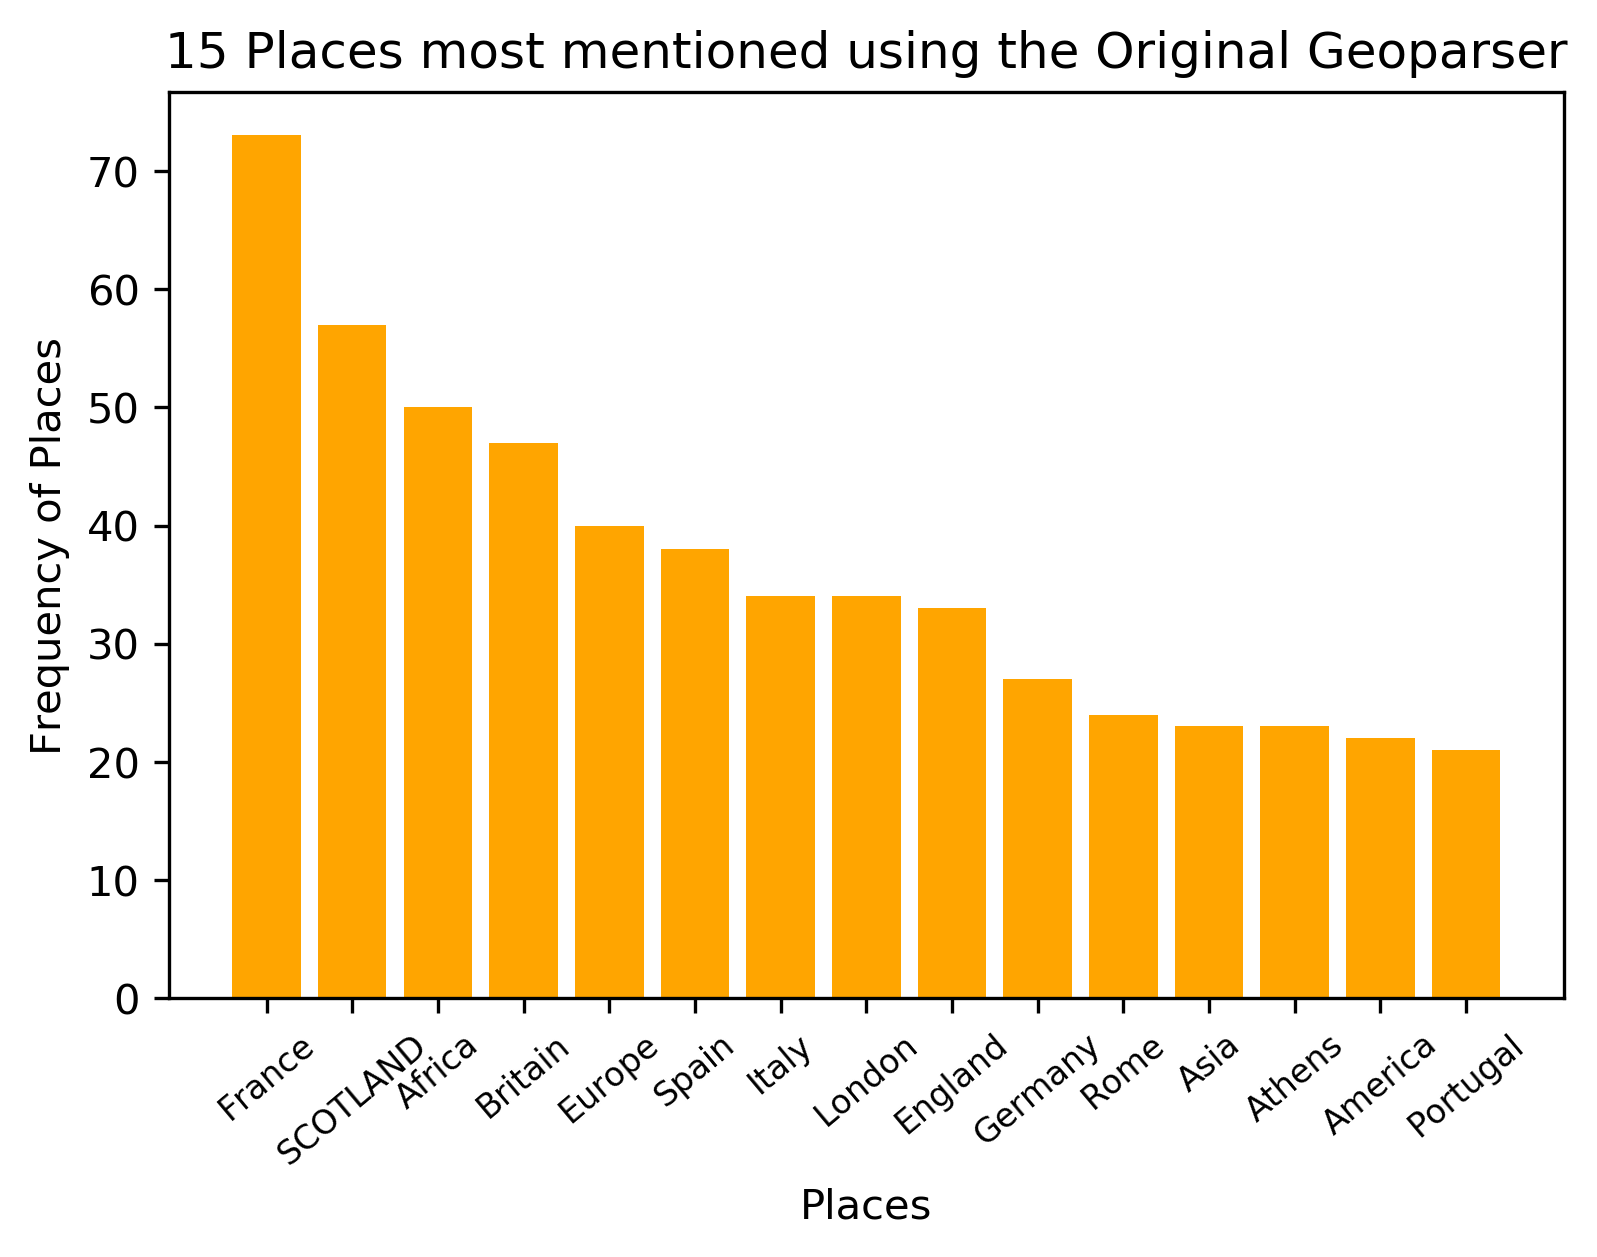

In [27]:
#Visualizing the 15 places in a Bar plot
plot_bar_places(place_label, place_freq)